# Power Network: Power flow simulation using Newton-Raphson algorithm

Why to do this:

- The basic model here only considers the supply and demand balance of the power network, doesn't include the price - thus not including optimization problems. We may only need this balance part, and the functions of PyPSA are too complicated.
- Neither I nor the WSP guy can smoothly use the Newton-Raphson algorithm of PyPSA. The results of this method are helpful in finding a good starting point for the optimization problem.
- A good attempt, and leave some record.

The whole solving process of the nonlinear equation system is elegant, especially by only solving specific parts of the equation system to achieve. It does NOT consider any optimization and constrain yet.

- Use the collected information to construct the node admittance matrix and the line impedance matrix.

- Construct the power injection vector, containing information on power injections at each bus.

- Set initial guesses for voltage phase and magnitude.

- Perform Newton-Raphson algorithm to solve inplicit part of the nonlinear equation system in power flow nodal analysis.

- Using the explicit equations, calculate the active injection at the slack bus and the reactive injections at the PV buses.

- Calculate line flows.

## 1. Collect Grid Parameters:

Here we will use an example network dataset to create our own basic power network model step by step. 

First, let's reviwe the data.

- Gather the topology of the grid, including:

  buses.csv, 

  lines.csv, 

  links.csv, 

  loads.csv, 

  generators.csv.

- Collect data on power injections at each bus at each snapshot, such as:

  loads-p_set.csv, 

  generators-p_max_pu.csv, 

  links-p_set.csv. 

  We can also set the nominal level or the limits number of "p" or "s" for lines, links and generators... But we don't set here to simplfy. Links-p_set here is the dispatch set point for p0 of the link in Power Flow.

- Gather parameters for the components, like the costs, impedances, admittances, etc. Here we haven't consider the optimization of power grid, so it is not necessary to read the cost data.

### 1.1 Read input data

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import csr_matrix, csc_matrix
# CSR format: suitable for scenarios where row slicing and row operations are efficient, 
#             such as matrix-vector multiplication and solving linear equations.
# CSC format: suitable for scenarios where column slicing and column operations are efficient, 
#             such as transposing matrices and column operations.
import sympy as sp

In [3]:
buses_df = pd.read_csv("./buses.csv")
generators_df = pd.read_csv("./generators.csv")
lines_df = pd.read_csv("./lines.csv")
links_df = pd.read_csv("./links.csv")
loads_df = pd.read_csv("./loads.csv")
carriers_df = pd.read_csv("./carriers.csv")
generatorspmaxpu_df = pd.read_csv("./generators-p_max_pu.csv")
linkspset_df = pd.read_csv("./links-p_set.csv")
loadspset_df = pd.read_csv("./loads-p_set.csv")
snapshots_df = pd.read_csv("./snapshots.csv")

Check the data below:

In [4]:
buses_df

,name,v_nom,carrier,x,y
0,London,380,AC,-0.13,51.50
1,Norwich,380,AC,1.30,52.60
2,Norwich DC,200,DC,1.30,52.50
3,Manchester,380,AC,-2.20,53.47
4,Bremen,380,AC,8.80,53.08
5,Bremen DC,200,DC,8.80,52.98
6,Frankfurt,380,AC,8.70,50.12
7,Norway,380,AC,10.75,60.00
8,Norway DC,200,DC,10.75,60.00


### 1.2 Build grid graph

#### 1.2.1 Build the network using the input data, including buses, generators, lines, links, loads, topology.

In [5]:
# create a new empty undirected graph
G = nx.Graph()

# add ids for nodes
buses_df["id"] =  range(len(buses_df))

# create a mapping of node names to ids
name_to_id = buses_df.set_index("name")["id"].to_dict()
id_to_name = {value: key for key, value in name_to_id.items()}

# add nodes from buses
for _, row in buses_df.iterrows():
    # iterate over DataFrame rows as (index, Series) pairs
    G.add_node(row["id"], name=row['name'], latitude=row['y'], longitude=row['x'], carrier=row['carrier'], vnom=row['v_nom'])
# add information of generators, loads

# add edges and attribution: lines, links
for _, row in lines_df.iterrows():
    from_node = name_to_id[row['bus0']]
    to_node = name_to_id[row['bus1']]
    impedance = row["r"] + 1j * row["x"]
    G.add_edge(from_node, to_node, impedance=impedance)
for _,row in links_df.iterrows():
    from_node = name_to_id[row['bus0']]
    to_node = name_to_id[row['bus1']]
    G.add_edge(from_node, to_node, efficiency=1)
    # set the efficiency = 1 to build lossless links

#### 1.2.2 Draw the network with location information.

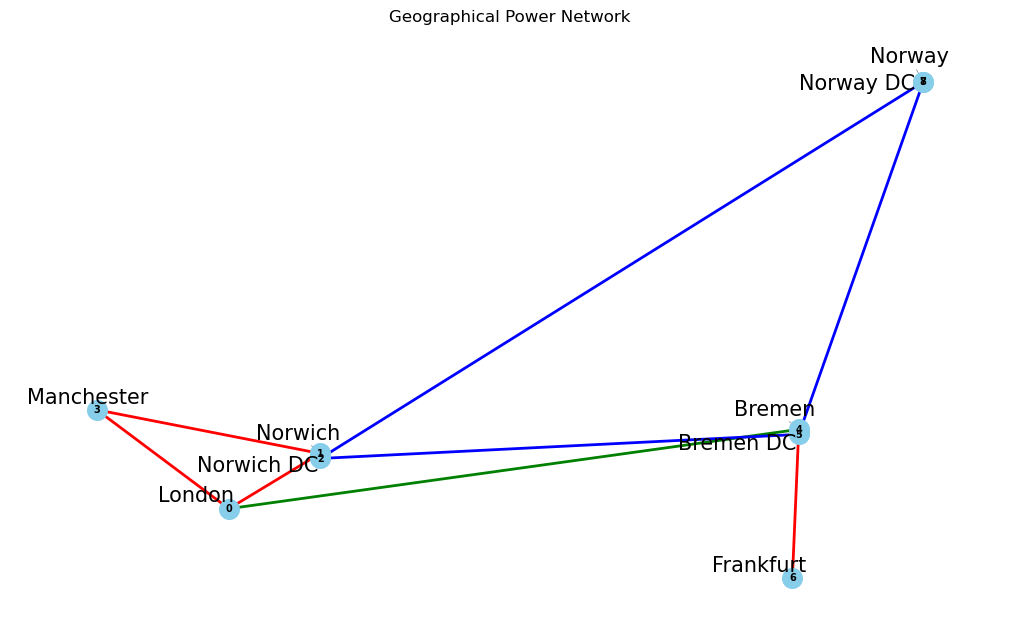

In [6]:
# read the location information of nodes
pos = {node: (data["longitude"], data['latitude']) for node, data in G.nodes(data=True)}
# if data is True then the attribute becomes the entire data dictionary

# set the edge color
edge_colors = []
for bus0, bus1, data in G.edges(data=True):
    if "efficiency" in data.keys():
        edge_colors.append("green")
        # links (eg. HVDC, converters...) are green
    elif G.nodes[bus0]["carrier"] == "DC":
        edge_colors.append("blue")
        # DC lines are blue
    elif G.nodes[bus0]["carrier"] == "AC":
        edge_colors.append("red")
        # AC lines are red

# plot the network
plt.figure(figsize=(10,6))
nx.draw(G, pos, with_labels=True, node_size=200, node_color='skyblue', font_size=7, 
        font_weight='bold', edge_color=edge_colors, width=2)

# plot the node labels
node_labels = nx.get_node_attributes(G, 'name')
#nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12)
texts = []
for node, (x, y) in pos.items():
    text = plt.text(x, y, node_labels[node], fontsize=15, ha='right', va='bottom')
    texts.append(text)

# adjust label position to avoid overlap
from adjustText import adjust_text
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographical Power Network')
plt.grid(True)
plt.show()

## 2. Prepare the system of equations

### 2.1 Build equations of passive branches: lines - admittance matrix

We calculate the admittance of each lines in order to build the admittance matrix following the Y matrix rules. We want the admittance matrix Y to be the same for all snapshots for convenience here.

In [7]:
name_to_id

{'London': 0,
 'Norwich': 1,
 'Norwich DC': 2,
 'Manchester': 3,
 'Bremen': 4,
 'Bremen DC': 5,
 'Frankfurt': 6,
 'Norway': 7,
 'Norway DC': 8}

In [8]:
lines_df

,name,b,bus0,bus1,capital_cost,s_nom,s_nom_extendable,x,r
0,0,0,London,Manchester,0.136716,40000,True,0.796878,0.000000
1,1,0,Manchester,Norwich,0.133492,40000,True,0.391560,0.000000
2,2,0,Bremen DC,Norwich DC,0.008673,40000,True,0.000000,0.212604
3,3,0,Norwich DC,Norway DC,0.129126,40000,True,0.000000,0.486164
4,4,0,Norway DC,Bremen DC,0.062430,40000,True,0.000000,0.428727
5,5,0,Norwich,London,0.021852,40000,True,0.238800,0.000000
6,6,0,Bremen,Frankfurt,0.200000,40000,True,0.400000,0.000000


In [ ]:
# learn the usage of ".inerrows"
lines_df
for index, row in lines_df.iterrows():
    print(name_to_id[row.bus0])

Calculate Y matrix (Admittance Matrix).

In [7]:
def creat_ymatrix(buses, lines):
    n = len(buses)
    ymatrix = np.zeros((n,n),dtype=complex)

    # we already have a mapping of node names to ids: name_to_id

    for index, row in lines.iterrows():
        # read the DF by row
        from_idx =  name_to_id[row.bus0]
        to_idx = name_to_id[row.bus1]
        impedance = row["r"] + 1j * row["x"]  # impedance is always positive, Ohm
        # print("r",row["r"],"x", row["x"], impedance)
        admittance = 1 / impedance  # Siemens
        ymatrix[from_idx, to_idx] -= admittance
        ymatrix[to_idx,from_idx] -= admittance
        ymatrix[from_idx,from_idx] += admittance
        ymatrix[to_idx,to_idx] += admittance

    return ymatrix


Try one snapshot first. To simplify our example, for every snapshot, the ymatrix is the same.

In [8]:
ymatrix = creat_ymatrix(buses_df,lines_df)
print(ymatrix[0]) # Siemens
print(ymatrix.shape)

[0.-5.44249541j 0.+4.18759862j 0.+0.j         0.+1.25489679j
 0.+0.j         0.+0.j         0.+0.j         0.+0.j
 0.+0.j        ]
(9, 9)


Seperate the imaginary and real part of the Ymatrix.

In [79]:
# apart the imaginary and real part of the Y matrix
# Y matrix is symmetrical along the diagonal

# real part
G = np.real(ymatrix)

# imaginary part
B = np.imag(ymatrix)

# check if G, B is right
he = G + 1j*B
if np.array_equal(ymatrix, he):
    print("yes")

# sparsity programming
sparse_G = csr_matrix(G)
sparse_B = csr_matrix(B)
#print(G,"\n", B)
print(G)

yes
[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    6.76  0.    0.   -4.7   0.    0.   -2.06]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.   -4.7   0.    0.    7.04  0.    0.   -2.33]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.   -2.06  0.    0.   -2.33  0.    0.    4.39]]


### 2.2 Build equations of dispatchable branches: links - efficiency

Here, we have links that are different from (AC and DC) lines. They can be used for any element with a controllable power flow: such as a bidirectional point-to-point HVDC link, a unidirectional lossy HVDC link, a converter between an AC and a DC network, a heat pump or resistive heater from an AC/DC bus to a heat bus. Because links don't have specific impedance, but can have an efficiency loss and a marginal cost, we set the efficiency of links as 1, that is "lossless". The flows in links are fully controllable. Networks of links implement Kirchoff’s Current Law (energy conservation at each bus), but not Kirchoff’s Voltage Law, which is obeyed by networks of passive branches.

Its default settings allow only for power flow in one direction, from bus0 to bus1. And active power at bus0 is positive if branch is withdrawing power from bus0.

In [36]:
links_df

,name,bus0,bus1,capital_cost,p_max_pu,p_min_pu,p_nom,p_nom_extendable,p_nom_min
0,Norwich Converter,Norwich,Norwich DC,0.210000,0.9,-0.9,1000,True,0
1,Norway Converter,Norway,Norway DC,0.200000,0.9,-0.9,1000,True,0
2,Bremen Converter,Bremen,Bremen DC,0.190000,0.9,-0.9,1000,True,0
3,DC link,London,Bremen,0.876534,0.9,-0.9,1000,True,0


## 3. Perform Newton-Raphson algorithm for power flow: solve the implicit equations until mismatches are sufficiently small.

### 3.1 Method overview

Use the Newton-Raphson method or other iterative methods to solve the power flow equations.
Formulate the power flow equations as a set of nonlinear equations involving node voltages and power injections.
Set convergence criteria, such as maximum iterations or error tolerance.

Steps of NR method:

- for all implicit equations whose P and Q is known, use NR method.(set there are m implicit equations, and every equation has )
- according Taylor first-order expansion at point $ (x_1^0, x_2^0,..., x_m^0) $, 
$$
f_i(x_1^0, x_2^0,..., x_m^0)+\sum_{j=1}^{m} \frac{\partial f}{\partial x_i} (x_i - x_i^0) = 0
$$
$$
i=1,2,...,m 
$$
It is easy to prove that the number of unknown parameters is equal to the number of equations, here we set it as m.

- rewrite in matrix form, and get the Jacobian matrix $ (m \times m)$ : $ J(x_1^0, x_2^0,..., x_m^0) $ at point $ (x_1^0, x_2^0,..., x_m^0) $
$$ 
\begin{pmatrix} 
\frac {\partial f_1(x_1^0, x_2^0,..., x_m^0)}{\partial x_1} & \frac {\partial f_1(x_1^0, x_2^0,..., x_m^0)}{\partial x_2} & ... & \frac{\partial f_1(x_1^0, x_2^0,..., x_m^0)}{\partial x_m} \\ 
\frac {\partial f_2(x_1^0, x_2^0,..., x_m^0)}{\partial x_1} & \frac {\partial f_2(x_1^0, x_2^0,..., x_m^0)}{\partial x_2} & ... & \frac{\partial f_2(x_1^0, x_2^0,..., x_m^0)}{\partial x_m} \\
\vdots & \vdots & ... & \vdots\\ 
\frac {\partial f_m(x_1^0, x_2^0,..., x_m^0)}{\partial x_1} & \frac {\partial f_m(x_1^0, x_2^0,..., x_m^0)}{\partial x_2} & ... & \frac{\partial f_m(x_1^0, x_2^0,..., x_m^0)}{\partial x_m}
\end{pmatrix}
$$

The matrix form of system of the implicit equations is:
$$
J(x_1^0, x_2^0,..., x_m^0) \times \begin{pmatrix} x_1-x_1^0 \\ x_2-x_2^0 \\ \vdots \\ x_m-x_m^0 \end{pmatrix} = - \begin{pmatrix} f_1(x_1^0, x_2^0,..., x_m^0) \\ f_2(x_1^0, x_2^0,..., x_m^0) \\ \vdots \\ f_m(x_1^0, x_2^0,..., x_m^0) \end{pmatrix}
$$

- invert the Jacobian matrix
$$ J(x_1^0, x_2^0,..., x_m^0)^{-1} $$

- calculate the corrections $ \Delta x_i, i=1,2,...,m$
$$
\begin{pmatrix} \Delta x_1 \\ \Delta x_2 \\ \vdots \\ \Delta x_m \end{pmatrix} =- J(x_1^0, x_2^0,..., x_m^0)^{-1} \begin{pmatrix} f_1(x_1^0, x_2^0,..., x_m^0) \\ f_2(x_1^0, x_2^0,..., x_m^0) \\ \vdots \\ f_m(x_1^0, x_2^0,..., x_m^0) \end{pmatrix}
$$
Considering the iteration, the equations become:

$$
\begin{pmatrix} x_1^{k+1} \\ x_2^{k+1} \\ \vdots \\ x_m^{k+1} \end{pmatrix} - \begin{pmatrix} x_1^{k} \\ x_2^{k} \\ \vdots \\ x_m^{k} \end{pmatrix} = \begin{pmatrix} \Delta x_1^k \\ \Delta x_2^k \\ \vdots \\ \Delta x_m^k \end{pmatrix} = - J(x_1^k, x_2^k,..., x_m^k)^{-1} \begin{pmatrix} f_1(x_1^k, x_2^k,..., x_m^k) \\ f_2(x_1^k, x_2^k,..., x_m^k) \\ \vdots \\ f_m(x_1^k, x_2^k,..., x_m^k) \end{pmatrix}
$$



### 3.2 Prepare the implicit equations using the real data
Apply NR method to the nodal power balance equations (only the implicit part), where the unknown parameters are voltage magnitude $V$ and phase $\theta$ at node. We need to use data of PV buses and PQ buses.

#### 3.2.1 Methodology

The nodal power balance can be expressed as followed:
Active power injection at bus k: 
$$
P_k = \sum_{i=1}^{N} V_k V_i [G_{ki}cos(\theta_{ki})+B_{ki}sin{\theta_{ki}}]
$$
$$
P_k = P_k^G - P_k^L
$$
Reactive power injection at bus k: 
$$
Q_k = \sum_{i=1}^{N} V_k V_i [G_{ki}sin(\theta_{ki})-B_{ki}cos{\theta_{ki}}]
$$
$$
Q_k = Q_k^G - Q_k^L
$$
Only use P and Q of PQ buses and P of PV buses which is classified as implicit equations.

#### 3.2.2  classify PQ, PV, slack buses, and other buses.
Other buses: without generators OR loads are otherbus, usually use for links: HVDC, inverters...

In [10]:
# check the Generator and load data to classify PQ, PV and slack buses (chapter 8 page 79-84). 

# Choose the first generator bus as the slack bus
first_row = next(generators_df.iterrows())[1]
slack = name_to_id[first_row["bus"]]

# Other generator buses are PVbus
PVbus = []
for index, row in generators_df.iterrows():
    node =  name_to_id[row["bus"]]
    if node != slack:
        if node not in PVbus:
            PVbus.append(node)
        
# buses with only loads are PQ buses
PQbus = []
for index, row in loads_df.iterrows():
    node =  name_to_id[row["bus"]]
    if node != slack:
        if node not in PVbus:
            if node not in PQbus:
                PQbus.append(node)

# Other buses without generators OR loads are otherbus, usually use for links: HVDC, inverters...
otherbus = []
for index, row in buses_df.iterrows():
    node = row["id"]
    if node != slack:
        if node not in PVbus:
            if node not in PQbus:
                otherbus.append(node)
# Classify other buses
for bus in otherbus:
    if id_to_name[bus] in links_df["bus1"].values:
        corresponding_bus0 = links_df.loc[links_df['bus1'] == id_to_name[bus], 'bus0'].tolist()[0]
        corresponding_id = name_to_id[corresponding_bus0]
        if corresponding_id in PQbus:
            PQbus.append(bus)
        else:
            #if is slack, also count as PV bus
            PVbus.append(bus)
#    elif id_to_name[bus] in links_df["bus0"].values:
                
print(slack)
print(PQbus)
print(PVbus)

3
[0, 1, 4, 2, 5]
[7, 6, 8]


#### 3.2.3 Add the attributes for each bus (for all snapshots)

In [35]:
# build up an empty dictionary to store corresponding known parameters for each bus
bus_attri = {}

# Add the known attributes as time-series data for each bus
# P: MW
# Q: MVar
# V: kV (Nominal voltage) 
# In Europe, 380kV is a common high voltage level used for national and cross-border power transmission.
# theta：radians

# As for the unknown parameters, we conly care about theta and V in implicit equations.
# Let's try flat start first: V = 380 (kV), theta = 0 (rad)

for time in snapshots_df["name"]:
    bus_attri[time] = {}

    #slack bus    
    bus_attri[time]["slack"] = {}
    V_slack = next(buses_df.iterrows())[1]["v_nom"]
    theta_slack = 0.0
    bus_attri[time]["slack"][slack] = {"V" :V_slack, "theta" :theta_slack, "P" :None, "Q" :None}

    #PV bus
    bus_attri[time]["PVbus"] = {}
    for id in PVbus:
        # p_nom (MW) :Nominal power for limits in optimization. 
        # Here because we havn't start to potimize, so for PQ buses let it be the known value.
        bus_attri[time]["PVbus"][id] = {}
        bus = id_to_name[id]

        #P = PG - PL + "links" #MW
        PG_rows = generators_df[generators_df["bus"] == bus]
        PG_PVbus = 0
        for name in PG_rows["name"]:           
            if name in generatorspmaxpu_df:
                row_index = generatorspmaxpu_df.index[generatorspmaxpu_df["snapshots"] == time].tolist()
                PG_pmaxpu = generatorspmaxpu_df.loc[row_index,name].values[0]
                # p_max_pu is the maximum output for each snapshot per unit of p_nom for the optimization 
            else:
                PG_pmaxpu = 1
            row_index_pnom = PG_rows.index[PG_rows["name"] == name].tolist()
            PG_vary = PG_rows.loc[row_index_pnom, "p_nom"].values[0] * PG_pmaxpu
            # may be more than one row, sum
            PG_PVbus = PG_PVbus + PG_vary
                
        if bus in loadspset_df:
            row_index_loads = loadspset_df.index[loadspset_df["snapshots"] == time].to_list()
            PL_PVbus = loadspset_df.loc[row_index_loads, bus].values[0]
        else:
            PL_PVbus = 0

        # Considering the links: positive means power from bus0 to bus1, so P_set for bus0:"-", for bus1:"+".
        if bus in links_df["bus0"].values:
            converter = links_df.loc[links_df["bus0"] == bus, "name"].tolist()[0]
            row_plink = linkspset_df.index[linkspset_df["snapshots"] == time].tolist()
            P_link_PVbus = - linkspset_df.loc[row_plink, converter].values[0]

        if bus in links_df["bus1"].values:
            converter = links_df.loc[links_df["bus1"] == bus, "name"].tolist()[0]
            row_plink = linkspset_df.index[linkspset_df["snapshots"] == time].tolist()
            P_link_PVbus = linkspset_df.loc[row_plink, converter].values[0]  

        bus_attri[time]["PVbus"][id]["P"] = PG_PVbus - PL_PVbus + P_link_PVbus

        # V = V_nom #kV
        V_rows = buses_df[buses_df["name"] == bus]
        V_PVbus = V_rows["v_nom"].values[0]
        bus_attri[time]["PVbus"][id]["V"] = V_PVbus

        # unknow Q; unknown theta has initial guess = 0.0 rad 
        bus_attri[time]["PVbus"][id]["Q"] = None
        bus_attri[time]["PVbus"][id]["theta"] = 0.0

    #PQ bus
    bus_attri[time]["PQbus"] = {}
    for id in PQbus:
        bus_attri[time]["PQbus"][id] = {}
        bus = id_to_name[id]

        # P = PG - PL + "links" #MW
        PG_rows = generators_df[generators_df["bus"] == bus]
        PG_PQbus = 0
        for name in PG_rows["name"]:           
            if name in generatorspmaxpu_df:
                row_index = generatorspmaxpu_df.index[generatorspmaxpu_df["snapshots"] == time].tolist()
                PG_pmaxpu = generatorspmaxpu_df.loc[row_index,name].values[0]
                # p_max_pu is the maximum output for each snapshot per unit of p_nom for the optimization 
            else:
                PG_pmaxpu = 1
            row_index_pnom = PG_rows.index[PG_rows["name"] == name].tolist()
            PG_vary = PG_rows.loc[row_index_pnom, "p_nom"].values[0] * PG_pmaxpu
            PG_PQbus = PG_PQbus + PG_vary    
        
        # the value of loads are time series data   
        if bus in loadspset_df:
            row_index_loads = loadspset_df.index[loadspset_df["snapshots"] == time].to_list()
            PL_PQbus = loadspset_df.loc[row_index_loads, bus].values[0]
        else:
            PL_PQbus = 0 
        
        # Considering the links: positive means power from bus0 to bus1, so P_set for bus0:"-", for bus1:"+".
        # if there is any link:
        if bus in links_df["bus0"].values:
            converter = links_df.loc[links_df["bus0"] == bus, "name"].tolist()[0]
            row_plink = linkspset_df.index[linkspset_df["snapshots"] == time].tolist()
            P_link_PQbus = - linkspset_df.loc[row_plink, converter].values[0]  # MW

        if bus in links_df["bus1"].values:
            converter = links_df.loc[links_df["bus1"] == bus, "name"].tolist()[0]
            row_plink = linkspset_df.index[linkspset_df["snapshots"] == time].tolist()
            P_link_PQbus = linkspset_df.loc[row_plink, converter].values[0]  
                  
        bus_attri[time]["PQbus"][id]["P"] = PG_PQbus - PL_PQbus + P_link_PQbus

        # Q = QG - QL #MVar
        # No Q data for generators and loads in our example, so here simply set as 0
        QG_rows = generators_df[generators_df["bus"] == bus]
        if "q_nom" in generators_df:
            # may be more than one row, sum
            QG_PQbus = QG_rows["q_nom"].sum()
        else:
            QG_PQbus = 0

        QL_rows =  loads_df[loads_df["bus"] == bus]
        if "q_nom" in loads_df:
            QL_PQbus = QL_rows["q_nom"].sum()
        else:
            QL_PQbus = 0

        # No Q data for LINKS in our example, so here simply set as 0
        Q_link_PQbus = 0
        bus_attri[time]["PQbus"][id]['Q'] = QG_PQbus - QL_PQbus + Q_link_PQbus

        # unknow V initial guess = 380 kV; unknown theta initial guess = 0.0 rad 
        bus_attri[time]["PQbus"][id]["V"] = 380
        bus_attri[time]["PQbus"][id]["theta"] = 0.0                                        
    
    #other buses as long as who connect with a link
    #bus_attri[time]["otherbus"] = {}
    #for id in otherbus:
            
    #    bus_attri[time]["otherbus"][id] = {'P': None, 'Q': None, 'V': None, 'theta': None}

print(bus_attri)

{'2015-01-01 00:00:00': {'slack': {3: {'V': 380, 'theta': 0.0, 'P': None, 'Q': None}}, 'PVbus': {7: {'P': 18861.9599201287, 'V': 380, 'Q': None, 'theta': 0.0}, 6: {'P': 79247.9882131999, 'V': 380, 'Q': None, 'theta': 0.0}, 8: {'P': 415.4625642653, 'V': 200, 'Q': None, 'theta': 0.0}}, 'PQbus': {0: {'P': -19.6879342565, 'Q': 0, 'V': 380, 'theta': 0.0}, 1: {'P': -451.258808368, 'Q': 0, 'V': 380, 'theta': 0.0}, 4: {'P': -656.1946873873, 'Q': 0, 'V': 380, 'theta': 0.0}, 2: {'P': 35.7962441027, 'Q': 0, 'V': 380, 'theta': 0.0}, 5: {'P': -451.258808368, 'Q': 0, 'V': 380, 'theta': 0.0}}}, '2015-01-01 01:00:00': {'slack': {3: {'V': 380, 'theta': 0.0, 'P': None, 'Q': None}}, 'PVbus': {7: {'P': 18930.6888444656, 'V': 380, 'Q': None, 'theta': 0.0}, 6: {'P': 79387.7778881259, 'V': 380, 'Q': None, 'theta': 0.0}, 8: {'P': 262.6061464526, 'V': 200, 'Q': None, 'theta': 0.0}}, 'PQbus': {0: {'P': -537.2535088083999, 'Q': 0, 'V': 380, 'theta': 0.0}, 1: {'P': -1239.4307079224, 'Q': 0, 'V': 380, 'theta': 0.0

#### 3.2.4 Set starting point for voltages and angles (only calculate one snapshot).
The unknown parameters in implicit equations are only theta and V of PQ, PV buses.

In [36]:
# The initial guess only include V and theta of PQ and PV bus. Others we don't set specifc values now.
def extract_keys(nested_dict, time, keys_to_extract, attri):
    """
    Extract specific keys (useful unknown parameters: V, theta of PV and PQ buses) from a nested dictionary and build a new dictionary.
    :param nested_dict: multi-level nested dictionary
    :param time: list of snapshots to extract
    :param keys_to_extract: list of types of buses to extract
    :param attri: name string "" of bus attribute to extract
    :return: new dictionary after extraction
    """
    if not isinstance(nested_dict, dict):
        return None

    new_dict = {}
    layer1 = {}
    layer2 = {}
    for key, value in nested_dict.items(): 
        if key in time:
            layer1 = value
            for key, value in layer1.items():
                if key in keys_to_extract:
                    layer2 = value
                    for busid, value in layer2.items():
                        new_dict[busid] = value[attri]
    return new_dict

# for implicite equations, only voltage and theta is unknown parameters.
time = ['2015-01-01 00:00:00']

P_known_extract = ["PVbus", "PQbus"]
P_unknown_extract = ["slack"]

Q_known_extract = ["PQbus"]
Q_unknown_extract = ["slack", "PVbus"]

V_known_extract = ["slack", "PVbus"]
V_unknown_extract = ["PQbus"]

theta_known_extract = ["slack"]
theta_unknown_extract = ["PVbus", "PQbus"]

P_known = extract_keys(bus_attri, time, P_known_extract, "P")
P_unknown = extract_keys(bus_attri, time, P_unknown_extract, "P")

Q_known = extract_keys(bus_attri, time, Q_known_extract, "Q")
Q_unknown = extract_keys(bus_attri, time, Q_unknown_extract, "Q")

V_known = extract_keys(bus_attri, time, V_known_extract, "V")
V_unknown = extract_keys(bus_attri, time, V_unknown_extract, "V")

theta_known = extract_keys(bus_attri, time, theta_known_extract, "theta")
theta_unknown = extract_keys(bus_attri, time, theta_unknown_extract, "theta")

P = {**P_known, **P_unknown}
Q = {**Q_known, **Q_unknown}
V = {**V_known, **V_unknown}
theta = {**theta_known, **theta_unknown}

print("P", P,"\n"
      "Q", Q, "\n"
      "V", V, "\n"
      "theta", theta)

P {7: 18861.9599201287, 6: 79247.9882131999, 8: 415.4625642653, 0: -19.6879342565, 1: -451.258808368, 4: -656.1946873873, 2: 35.7962441027, 5: -451.258808368, 3: None} 
Q {0: 0, 1: 0, 4: 0, 2: 0, 5: 0, 3: None, 7: None, 6: None, 8: None} 
V {3: 380, 7: 380, 6: 380, 8: 200, 0: 380, 1: 380, 4: 380, 2: 380, 5: 380} 
theta {3: 0.0, 7: 0.0, 6: 0.0, 8: 0.0, 0: 0.0, 1: 0.0, 4: 0.0, 2: 0.0, 5: 0.0}


### 3.3 Perform Newton-Raphson algorithm to solve equations (Only calculate for the first snapshot as an example)

The equations with known P and Q are called implicit equations. 

By solving this implicit part of equation system using N-R method, we can calculate the value of unknown V and theta. 

Then use the rest explicit equations of equation system to calculate the rest unknown P and Q. 

In this way, all unknow parameters are solved. Once get the P, Q, V, theta of every bus in the power network, calculate the lines flows for futher applications.

#### 3.3.1 Define the equations:
For implicite equations, only voltage and theta is unknown parameters.

In [38]:
# After considering the links, the implicit bus contains all buses.
implicit_bus = [slack] + PVbus + PQbus

# define the symbols
# V_k, V_i, G_ki, B_ki, theta_ki, P_k, Q_k = sp.symbols("V_k V_i G_ki B_ki theta_ki P_k Q_k")
# i, N = sp.symbols("i N", integer=True)
# # define the function
# # for P function, we use: P_known, Q_known, V_known, theta_known, V_unknown, theta_unknown
# Pfunction = V_k * V_i * (G_ki * sp.cos(theta_ki) + B_ki * sp.sin(theta_ki))
# Qfunction =  V_k * V_i * (G_ki * sp.sin(theta_ki) - B_ki * sp.cos(theta_ki))

# P: MW
# Q: MVar
# V: kV (Nominal voltage)
# theta：rad

def fp_cal(V, theta, k, P, G, B, implicit_bus):
    # Define power flow equations
    # param known: P, Q, G, B: dictionary containing active power P and reactive power Q of buses
    # param unknown: V, theta: dictionary containing voltages and phase angles of buses
    # param k: an integer meaning the k'th bus
    V_k = V[k]
    P_k = P[k]
    fpsum = 0
    for i in implicit_bus:    
        V_i = V[i]  # kV
        theta_ki = theta[k] - theta[i]  # rad
        G_ki = G[k, i]  # conductance: Siemens
        B_ki = B[k, i]  # susceptance: Siemens
        fpsum += V_k * V_i * (G_ki * sp.cos(theta_ki) + B_ki * sp.sin(theta_ki))
    # Transform the function into the left side of the equation
    fpsum -= P_k
    # Unit of fpsum:  MW    
    return fpsum
   
def fq_cal(V, theta, k, Q, G, B, implicit_bus):
    V_k = V[k]
    Q_k = Q[k]
    fqsum = 0
    for i in implicit_bus:    
        V_i = V[i]  # kV
        theta_ki = theta[k] - theta[i]  # rad
        G_ki = G[k, i]  # conductance: Siemens
        B_ki = B[k, i]  # conductance: Siemens
        fqsum += V_k * V_i * (G_ki * sp.sin(theta_ki) - B_ki * sp.cos(theta_ki))
    # Transform the function into the left side of the equation
    fqsum -= Q_k
    # Unit of fqsum:  MVar    
    return fqsum

#### 3.3.2 Calculate the mismatches and relabel to get the vector of f (P & Q).

In [39]:
fp_result = {}
fq_result = {}

for i in PVbus:
    fp_result[i] = fp_cal(V, theta, i, P, G, B, implicit_bus)

for i in PQbus:
    fp_result[i] = fp_cal(V, theta, i, P, G, B, implicit_bus)
    fq_result[i] = fq_cal(V, theta, i, Q, G, B, implicit_bus)

# get the mapping rule of row-index to bus ID.
# Here the mapping means to skip the slack "3".
# P
Plist = PQbus + PVbus
sorted_Plist = enumerate(sorted(Plist))
P_mapping = {index: value for index, value in sorted_Plist}
fp_vector = [fp_result[value] for key,value in P_mapping.items()]
# Q
sorted_Qlist = enumerate(sorted(PQbus))
Q_mapping = {index: value for index, value in sorted_Qlist}
fq_vector = [fq_result[value] for key, value in Q_mapping.items()]

print(fp_result)
print(fq_result)
print(fp_vector)
print(fq_vector)

{7: -18861.9599201287, 6: -79247.9882131999, 8: -158434.174571772, 0: 19.6879342565000, 1: 451.258808368000, 4: 656.194687387300, 2: 140657.539990289, 5: 159993.475388239}
{0: 0, 1: 0, 4: 0, 2: 0, 5: 0}
[19.6879342565000, 451.258808368000, 140657.539990289, 656.194687387300, 159993.475388239, -79247.9882131999, -18861.9599201287, -158434.174571772]
[0, 0, 0, 0, 0]


### 3.3.3 Build the Jacobian matrix

#### 3.3.3.1 Review the methedology

The Jacobian matrix $ (m \times m)$ : $ J(x_1^0, x_2^0,..., x_m^0) $ at point $ (x_1^k, x_2^k,..., x_m^k) $
$$ 
\begin{pmatrix} 
\frac {\partial f_1(x_1^k, x_2^k,..., x_m^k)}{\partial x_1} & \frac {\partial f_1(x_1^k, x_2^k,..., x_m^k)}{\partial x_2} & ... & \frac{\partial f_1(x_1^k, x_2^k,..., x_m^k)}{\partial x_m} \\ 
\frac {\partial f_2(x_1^k, x_2^k,..., x_m^k)}{\partial x_1} & \frac {\partial f_2(x_1^k, x_2^k,..., x_m^k)}{\partial x_2} & ... & \frac{\partial f_2(x_1^k, x_2^k,..., x_m^k)}{\partial x_m} \\
\vdots & \vdots & ... & \vdots\\ 
\frac {\partial f_m(x_1^k, x_2^k,..., x_m^k)}{\partial x_1} & \frac {\partial f_m(x_1^k, x_2^k,..., x_m^k)}{\partial x_2} & ... & \frac{\partial f_m(x_1^k, x_2^k,..., x_m^k)}{\partial x_m}
\end{pmatrix}
$$


In our code， the subscript of $f$ corresponds to the bus id (from 0 to n-1).

$f$ consists of p and q functions, and $x$ includes V and theta. So Jacobian matrix can be written and divided into 4 parts as below:
$$
J = \begin{pmatrix}
\frac {\partial P_2}{\partial \theta_2} & \cdots & \frac {\partial P_2}{\partial \theta_{N}} &| &
\frac {\partial P_2}{\partial V_{m+1}} & \cdots & \frac {\partial P_2}{\partial V_N} \\
\vdots & \ddots & \vdots &|& \vdots & \ddots & \vdots \\
\frac {\partial P_N}{\partial \theta_2} & \cdots & \frac {\partial P_N}{\partial \theta_{N}} &| &
\frac {\partial P_N}{\partial V_{m+1}} & \cdots & \frac {\partial P_N}{\partial V_N} \\
---&---&---&---&---&---&---\\
\frac {\partial Q_{m+1}}{\partial \theta_2} & \cdots & \frac {\partial Q_{m+1}}{\partial \theta_{N}} & |&
\frac {\partial Q_{m+1}}{\partial V_{m+1}} & \cdots & \frac {\partial Q_{m+1}}{\partial V_N} \\
\vdots & \ddots & \vdots &|& \vdots & \ddots & \vdots \\
\frac {\partial Q_N}{\partial \theta_2} & \cdots & \frac {\partial Q_N}{\partial \theta_{N}} & |&
\frac {\partial Q_N}{\partial V_{m+1}} & \cdots & \frac {\partial Q_N}{\partial V_N} 
\end{pmatrix} 
= \begin{pmatrix}
H &|& M \\ ---&---&--- \\ N &|&  L
\end{pmatrix}
$$

Specifically, substitute into the calculation formula of P and Q, we get:
$$
P_k(\theta_2,...,\theta_N, V_{m+1},...,V_N) = \sum_{i=1}^{N} V_k V_i [G_{ki}cos(\theta_{ki})+B_{ki}sin{\theta_{ki}}] - P_k
$$
$$
Q_k(\theta_2,...,\theta_N, V_{m+1},...,V_N) = \sum_{i=1}^{N} V_k V_i [G_{ki}sin(\theta_{ki})- B_{ki}cos{\theta_{ki}}] - Q_k
$$
- H terms of Jacobian matrix:
$$
For \left\{ 
    \begin{aligned}
    & i \neq k:  \\
    & H_{ki} = \frac {\partial P_k}{\partial \theta_i} = V_k V_i[G_{ki} \sin(\theta_k - \theta_i) - B_{ki} \cos(\theta_k - \theta_i)]\\
    & i = k: \\
    & H_{kk} = \frac {\partial P_k}{\partial \theta_k} = \sum_{i=1\\(i \neq k)}^{N} V_k V_i[-G_{ki} \sin(\theta_k - \theta_i) + B_{ki} \cos(\theta_k - \theta_i)]
    \end{aligned}
\right.
$$
- M terms of Jacobian matrix:
$$
For \left\{ 
    \begin{aligned}
    & i \neq k:  \\
    & M_{ki} = \frac {\partial P_k}{\partial V_i} = V_k[G_{ki} \cos(\theta_k - \theta_i) + B_{ki} \sin(\theta_k - \theta_i)]\\
    & i = k: \\
    & M_{kk} = \frac {\partial P_k}{\partial V_k} = 2G_{kk}V_k + \sum_{i=1\\(i \neq k)}^{N} V_i[G_{ki} \cos(\theta_k - \theta_i) + B_{ki} \sin(\theta_k - \theta_i)]
    \end{aligned}
\right.
$$
- N terms of Jacobian matrix:
$$
For \left\{ 
    \begin{aligned}
    & i \neq k:  \\
    & N_{ki} = \frac {\partial Q_k}{\partial \theta_i} = V_k V_i[-G_{ki} \cos(\theta_k - \theta_i) - B_{ki} \sin(\theta_k - \theta_i)]\\
    & i = k: \\
    & N_{kk} = \frac {\partial Q_k}{\partial \theta_k} = \sum_{i=1\\(i \neq k)}^{N} V_i V_k[G_{ki} \cos(\theta_k - \theta_i) + B_{ki} \sin(\theta_k - \theta_i)]
    \end{aligned}
\right.
$$
- L terms of Jacobian matrix:
$$
For \left\{ 
    \begin{aligned}
    & i \neq k:  \\
    & L_{ki} = \frac {\partial Q_k}{\partial V_i} = V_k[G_{ki} \sin(\theta_k - \theta_i) - B_{ki} \cos(\theta_k - \theta_i)]\\
    & i = k: \\
    & L_{kk} = \frac {\partial Q_k}{\partial V_k} = - 2B_{kk}V_k + \sum_{i=1\\(i \neq k)}^{N} V_i[G_{ki} \sin(\theta_k - \theta_i) - B_{ki} \cos(\theta_k - \theta_i)]
    \end{aligned}
\right.
$$

- More details: 

H terms: P (id in P_known) v.s. theta (id in theta_unknown), dimension: PN * thetaN

M terms: P (id in P_known) v.s. V (id in V_unknown), dimension: PN * VN

N terms: Q (id in Q_known) v.s. theta (id in theta_unknown), dimension: QN * thetaN

L terms: Q (id in Q_known) v.s. V (id in V_unknown), dimension: QN * VN

J: (PN + QN) * (thetaN + VN)

#### 3.3.3.2 Some preparation.

In [42]:
# number of buses involved in the implicit system of equations: N
N = len(implicit_bus)
# number of PQ buses: PQN, number of PV buses: PVN
PQN = len(PQbus)
PVN = len(PVbus)
# equation number: EN
EN = 2*PQN + PVN
# P function number: PN, Q function number: QN
PN = PQN + PVN
QN = PQN
# unknown parameter V number: VN, theta number: thetaN
VN = PQN 
thetaN = PQN + PVN 
# number of rows/columns of J matrix
JN = PN + QN

In [55]:
print("PN=", PN, "QN=", QN, "thetaN=", thetaN, "VN=", VN )

PN= 8 QN= 5 thetaN= 8 VN= 5


IMPORTANT: To make sure that the Jacobian matrix is ​​reversible, it is necessary to delete the IDs of other buses and slack bus, and re-label them as the coordinates of the J matrix.

In [47]:
# get the mapping rule of row/column-index to bus ID. Mapping can be used as subscripts.
# P
Plist = PQbus + PVbus
sorted_Plist = enumerate(sorted(Plist))
P_mapping = {index: value for index, value in sorted_Plist}
fp_vector = [fp_result[value] for key,value in P_mapping.items()]
# Q
sorted_Qlist = enumerate(sorted(PQbus))
Q_mapping = {index: value for index, value in sorted_Qlist}
fq_vector = [fq_result[value] for key, value in Q_mapping.items()]
# theta
theta_mapping = P_mapping
# V
V_mapping = Q_mapping

In [78]:
P_mapping

{0: 0, 1: 1, 2: 2, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8}

#### 3.3.3.3 Build the $H, M, N, L$ matrix to get Jacobian matrix $J$

In [73]:
def J_cal(PN, QN, thetaN, VN, JN, V, G, B, theta, theta_mapping, P_mapping, V_mapping, Q_mapping, implicit_bus):
    J_matrix = np.zeros((JN,JN),dtype=complex)

    #H_matrix
    H_matrix = np.zeros((PN,thetaN),dtype=complex)
    for j in range(thetaN):
        for k in range(PN):
            if theta_mapping[j] != P_mapping[k]:
                # mapping: row/column-index to bus ID
                H_matrix[k,j] = V[P_mapping[k]] * V[theta_mapping[j]] * (G[P_mapping[k], theta_mapping[j]] * sp.sin(theta[P_mapping[k]] - theta[theta_mapping[j]]) - B[P_mapping[k], theta_mapping[j]] * sp.cos(theta[P_mapping[k]] - theta[theta_mapping[j]]))
            elif theta_mapping[j] == P_mapping[k]:
                for i in implicit_bus:
                    # bus ID in "implicit bus" list
                    if i != P_mapping[k]:
                        element = V[P_mapping[k]] * V[i] * (-G[P_mapping[k],i] * sp.sin(theta[P_mapping[k]] - theta[i]) + B[P_mapping[k],i] * sp.cos(theta[P_mapping[k]] - theta[i]))
                    H_matrix[k,k] += element

    #M_matrix
    M_matrix = np.zeros((PN,VN),dtype=complex)
    for j in range(VN):
        for k in range(PN):
            if V_mapping[j] != P_mapping[k]:
                M_matrix[k,j] = V[P_mapping[k]] * (G[P_mapping[k], V_mapping[j]] * sp.cos(theta[P_mapping[k]] - theta[V_mapping[j]]) + B[P_mapping[k], V_mapping[j]] * sp.sin(theta[P_mapping[k]] - theta[V_mapping[j]]) + B[P_mapping[k], V_mapping[j]] * sp.sin(theta[P_mapping[k]] - theta[V_mapping[j]]))
            elif V_mapping[j] == P_mapping[k]:
                for i in implicit_bus:
                    if i != P_mapping[k]:
                        element = V[i] * (G[P_mapping[k],i] * sp.cos(theta[P_mapping[k]] - theta[i]) + B[P_mapping[k],i] * sp.sin(theta[P_mapping[k]] - theta[i]))
                    M_matrix[k,k] += element 
                M_matrix[k,k] += 2 * G[P_mapping[k],P_mapping[k]] * V[P_mapping[k]]

    #N_matrix
    N_matrix = np.zeros((QN,thetaN),dtype=complex)
    for j in range(thetaN):
        for k in range(QN):
            if theta_mapping[j] != Q_mapping[k]:
                N_matrix[k,j] = V[Q_mapping[k]] * V[theta_mapping[j]] * (-G[Q_mapping[k],theta_mapping[j]] * sp.cos(theta[Q_mapping[k]] - theta[theta_mapping[j]]) - B[Q_mapping[k],theta_mapping[j]] * sp.sin(theta[Q_mapping[k]] - theta[theta_mapping[j]]))
            elif theta_mapping[j] == Q_mapping[k]:
                for i in implicit_bus:
                    if i != Q_mapping[k]:
                        element = V[Q_mapping[k]] * V[i] * (G[Q_mapping[k],i] * sp.cos(theta[Q_mapping[k]] - theta[i]) + B[Q_mapping[k],i] * sp.sin(theta[Q_mapping[k]] - theta[i]))
                    N_matrix[k,k] += element 

    #L_matrix
    L_matrix = np.zeros((QN,VN),dtype=complex)
    for j in range(VN):
        for k in range(QN):
            if V_mapping[j] != Q_mapping[k]:
                L_matrix[k,j] = V[Q_mapping[k]] * (G[Q_mapping[k],V_mapping[j]] * sp.sin(theta[Q_mapping[k]] - theta[V_mapping[j]]) - B[Q_mapping[k],V_mapping[j]] * sp.cos(theta[Q_mapping[k]] - theta[V_mapping[j]]))
            elif V_mapping[j] == Q_mapping[k]:
                for i in implicit_bus:
                    if i != Q_mapping[k]:
                        element = V[i] * (G[Q_mapping[k],i] * sp.sin(theta[Q_mapping[k]]-theta[i]) - B[Q_mapping[k],i]* sp.cos(theta[Q_mapping[k]] - theta[i]))
                    L_matrix[k,k] += element 
                L_matrix += -2 * B[Q_mapping[k],Q_mapping[k]] * V[Q_mapping[k]]

    #J_matrix
    top = np.hstack((H_matrix, M_matrix))  # Splice H and M left and right to calculate
    bottom = np.hstack((N_matrix, L_matrix))  # Splice N and L left and right to calculate
    J_matrix = np.vstack((top, bottom))

    return J_matrix, H_matrix, M_matrix, N_matrix, L_matrix

In [77]:
all_result = J_cal(PN, QN, thetaN, VN, JN, V, G, B, theta, theta_mapping, P_mapping, V_mapping, Q_mapping, implicit_bus)
J_matrix, H_matrix, M_matrix, N_matrix, L_matrix = all_result
#np.set_printoptions(precision=2, suppress=True)
#df = pd.DataFrame(J_result)
print(H_matrix[6,6])

0j


#### 3.3.3.4 Invert the Jacobian matrix

Considering the iteration, then the implicit part of the power flow equation system becomes:

$$
\begin{pmatrix} x_1^{k+1} \\ x_2^{k+1} \\ \vdots \\ x_m^{k+1} \end{pmatrix} - \begin{pmatrix} x_1^{k} \\ x_2^{k} \\ \vdots \\ x_m^{k} \end{pmatrix} = \begin{pmatrix} \Delta x_1^k \\ \Delta x_2^k \\ \vdots \\ \Delta x_m^k \end{pmatrix} 
= - J(x_1^k, x_2^k,..., x_m^k)^{-1} \begin{pmatrix} f_1(x_1^k, x_2^k,..., x_m^k) \\ f_2(x_1^k, x_2^k,..., x_m^k) \\ \vdots \\ f_m(x_1^k, x_2^k,..., x_m^k) \end{pmatrix}
$$

In [80]:
try:
    inverse_J = np.linalg.inv(J_result)
    print("逆矩阵:")
    print(inverse_J)
except np.linalg.LinAlgError:
    print("矩阵不可逆。")

# 找到全零行
zero_rows = np.where(~J_result.any(axis=1))[0]
# 找到全零列
zero_columns = np.where(~J_result.any(axis=0))[0]
#if zero_columns == zero_rows:
#    if zero_rows 小于等于 H 的rows数：
#        直接用Pmapping反求ID
#    else:
#        用Qmapping反求id，index为zero——rows - hrow数减一
#    zero_busID = 

print("全零行的索引:", zero_rows)
print("全零列的索引:", zero_columns)

矩阵不可逆。
全零行的索引: [6]
全零列的索引: [6]


### 3.3.4 Iteration

### 3.3.5 Calculate the corrections

2. covert to python step by step.
- apply NR method to the nodal power balance equations (only the implicit part), where the unknown parameters are voltage magnitude $V$ and phase $\theta$ at node.

ok@对示例中的bus分类

为每一个node设定种类，对应的已知量和未知量，

有个问题：既有generator又有loads被归类为PV bus，P是根据G还是L确定？根据G的话，通常比L大，是不是应该等于G-L，因为这里的P 是injection

使用正确的Ymatrix的real or imaginary part

设置初始值, 只有电压 magnitude和phase

把f函数写出来，计算初始点的函数值

#### NOW! 把jmatrix 写出来，然后求逆。

然后迭代。

如何迭代更新值？更新对应的字典：即V_unknown, theta_unknown？

迭代求解直到误差足够小

3. run an example.
例子里面先不跑other bus，方程和未知数暂时对不上
有必要还可以跑一个三个node的例子

Question: 

Sparsity Programming

how to convert to sparse matrix?

read the example on page 126, decide the next step

recall the N-R ssolving process, how to define the links?

### Is there any preconstrains like: < the p_non

用vector表示而不是dic？

数据的结构-浮点数，应该设置到小数点后面多少位就可以？

看看julia - github 上star的那个repository

power flow 不平衡的后果是什么？

领英上看到很多有关电网和AI的书，看看有什么不同，有什么帮助，有什么趋势？

If add a constrain to do a optimization?

### 3.4 Update the voltage magnitudes and angles until mismatches are sufficiently small

## 4. Using the explicit equations, calculate the active injection at the slack bus and the reactive injections at the PV buses


## 5. Calculate the line flows (for different snapshots?).

## 6. Analyse Power Flow Results:

Check the computed results to ensure voltage stability and power balance.
Analyse the power flow results to identify flow constraints or problematic nodes.
Optionally: Perform fault analysis or load forecasting.

## 7. Optimize Grid Operations (Optional):

Model grid operations as an optimization problem, such as minimizing power losses or maximizing voltage stability.
Use optimization algorithms to find the optimal solution.
Analyse the optimization results to assess the effectiveness of operational recommendations.

In [ ]:
import numpy as np

# Step 1: Collect Grid Parameters
# Collect topology information, power injections, line parameters, etc.

# Step 2: Build Grid Model
# Construct node admittance matrix, line impedance matrix, and power injection vector
# Set initial guesses for voltage magnitudes and phases

# Step 3: Perform Power Flow Calculation
def power_flow_equations(x):
    # Define power flow equations
    # x: vector containing voltages and phase angles of buses
    # Implement power flow equations here
    return result

initial_guess = np.zeros(num_buses * 2)  # Initial guess for voltages and phase angles
result = minimize(power_flow_equations, initial_guess)

if result.success:
    voltages = result.x[:num_buses]
    phase_angles = result.x[num_buses:]
    # Print or further process results
else:
    print("Power flow calculation failed.")

# Step 4: Analyse Power Flow Results
# Check voltage stability, power balance, flow constraints, etc.

# Step 5: Optimize Grid Operations (Optional)
def objective_function(x):
    # Define objective function for optimization
    # x: vector containing control variables (e.g., power injections)
    # Implement objective function here
    return result

optimization_result = minimize(objective_function, initial_guess)

if optimization_result.success:
    optimal_controls = optimization_result.x
    # Print or further process optimization results
else:
    print("Optimization failed.")
